# Edge Impulse: Cifar10 - Image Classification Explained
 - Using a CNN Classifier

## Import Main Libraries

In [31]:
import sys, os, random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, BatchNormalization, TimeDistributed
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Download the data
1. Go to your project or clone this one:
    - https://studio.edgeimpulse.com/public/51070/latest
2. On `Dashboard` Tab, download the data files:

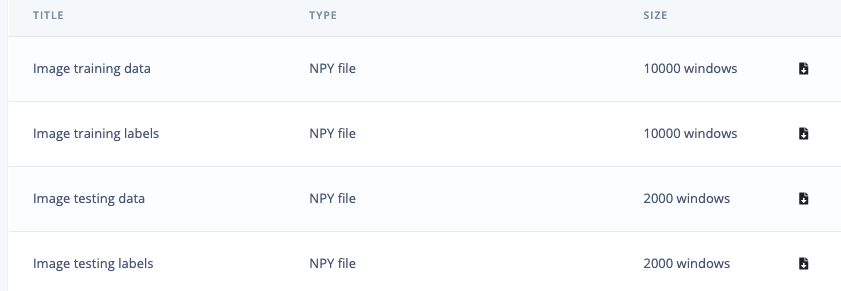

3. On the CoLab Lateral panel, upload the training files

In [4]:
!ls

ei-cifar10_image_classification-image-X_training.npy  sample_data
ei-cifar10_image_classification-image-y_training.npy


### Load data through Numpy.

In [18]:
# Define data path
X_path = 'ei-cifar10_image_classification-image-X_training.npy'
Y_path = 'ei-cifar10_image_classification-image-y_training.npy'

# Load the data
X = np.load(X_path)
Y = np.load(Y_path)[:,0]

#data_shape
X.shape, Y.shape

((10000, 3072), (10000,))

	 Label Image==>  2


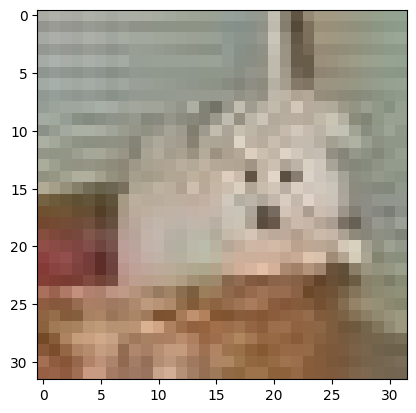

In [20]:
image = X[0]
label = Y[0]
reshape_to = (32,32,3)

print("\t Label Image==> ",label)
img = tf.reshape(image, reshape_to)
plt.imshow(img);

Define our labels and split the data up in a test and training set:

In [22]:
# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

classes_values = [ "cat", "dog" ]
classes = len(classes_values)
classes

2

In [23]:
Y

array([2, 2, 2, ..., 1, 1, 1], dtype=int32)

In [24]:
set(Y)

{1, 2}

In [25]:
Y = tf.keras.utils.to_categorical(Y - 1, classes)
Y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

print(X_train.shape, Y_test.shape)
print(X_test.shape, Y_test.shape)

(8000, 3072) (2000, 2)
(2000, 3072) (2000, 2)


In [27]:
input_length = X_train[0].shape[0]
input_length

3072

The [tf.data API](https://www.tensorflow.org/guide/data) enables you to build complex input pipelines from simple, reusable pieces. For example, the pipeline for an image model might aggregate data from files in a distributed file system, apply random perturbations to each image, and merge randomly selected images into a batch for training.

In [28]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [29]:
print(train_dataset)
print(validation_dataset)

<_TensorSliceDataset element_spec=(TensorSpec(shape=(3072,), dtype=tf.float32, name=None), TensorSpec(shape=(2,), dtype=tf.float32, name=None))>
<_TensorSliceDataset element_spec=(TensorSpec(shape=(3072,), dtype=tf.float32, name=None), TensorSpec(shape=(2,), dtype=tf.float32, name=None))>


In [30]:
def get_reshape_function(reshape_to):
    def reshape(image, label):
        return tf.reshape(image, reshape_to), label
    return reshape

callbacks = []

Train the model:

In [32]:
# model architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(Conv2D(64, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(64, activation='relu',
    activity_regularizer=tf.keras.regularizers.l1(0.00001)))
model.add(Dense(classes, activation='softmax', name='y_pred'))

In [34]:
# this controls the learning rate
opt = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)

In [35]:
# This is only required for some input types, e.g. images
SPECIFIC_INPUT_SHAPE = (32, 32, 3)

train_dataset = train_dataset.map(get_reshape_function(SPECIFIC_INPUT_SHAPE), tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.map(get_reshape_function(SPECIFIC_INPUT_SHAPE), tf.data.experimental.AUTOTUNE)

In [36]:
print(train_dataset)
print(validation_dataset)

<_ParallelMapDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(2,), dtype=tf.float32, name=None))>
<_ParallelMapDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(2,), dtype=tf.float32, name=None))>


In [37]:
# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

In [38]:
print(train_dataset)
print(validation_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>


In [39]:
# compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
    )

In [40]:
# train the neural network
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    verbose=2,
    callbacks=callbacks
    )

Epoch 1/10
250/250 - 15s - loss: 0.6639 - accuracy: 0.5946 - val_loss: 0.6872 - val_accuracy: 0.5855 - 15s/epoch - 59ms/step
Epoch 2/10
250/250 - 13s - loss: 0.6066 - accuracy: 0.6658 - val_loss: 0.6444 - val_accuracy: 0.6370 - 13s/epoch - 52ms/step
Epoch 3/10
250/250 - 15s - loss: 0.5659 - accuracy: 0.7031 - val_loss: 0.6169 - val_accuracy: 0.6655 - 15s/epoch - 59ms/step
Epoch 4/10
250/250 - 13s - loss: 0.5329 - accuracy: 0.7281 - val_loss: 0.6003 - val_accuracy: 0.6850 - 13s/epoch - 53ms/step
Epoch 5/10
250/250 - 13s - loss: 0.5020 - accuracy: 0.7535 - val_loss: 0.5826 - val_accuracy: 0.7000 - 13s/epoch - 53ms/step
Epoch 6/10
250/250 - 13s - loss: 0.4702 - accuracy: 0.7774 - val_loss: 0.5695 - val_accuracy: 0.7145 - 13s/epoch - 51ms/step
Epoch 7/10
250/250 - 13s - loss: 0.4376 - accuracy: 0.7979 - val_loss: 0.5767 - val_accuracy: 0.7225 - 13s/epoch - 53ms/step
Epoch 8/10
250/250 - 13s - loss: 0.4026 - accuracy: 0.8192 - val_loss: 0.5915 - val_accuracy: 0.7285 - 13s/epoch - 51ms/step


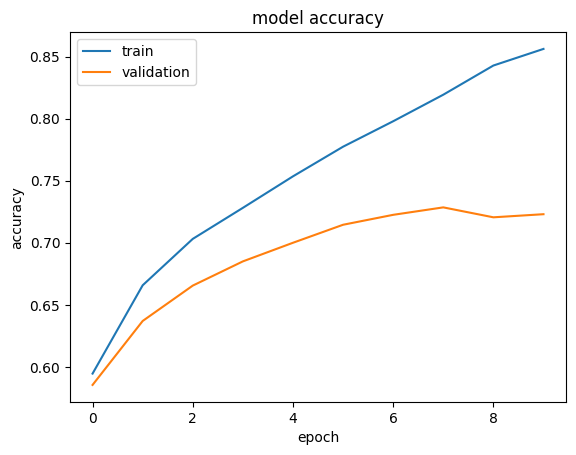

In [41]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [42]:
# Save the model to disk
model.save('saved_model')

# Test Model

### Single image test

In [44]:
my_image = X_test[1]
my_image.shape

(3072,)

In [45]:
my_image = my_image.reshape(1,32,32,3)
my_image.shape

(1, 32, 32, 3)

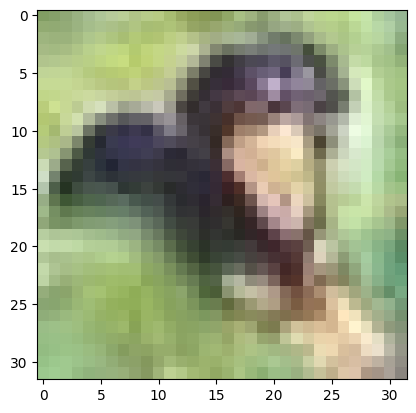

In [46]:
plt.imshow(my_image.reshape(32,32,3));

In [47]:
img_pred = np.argmax(model.predict(my_image))
pred_label = classes_values[img_pred]
pred_label

1/1 [==============================] - 0s 115ms/step


'dog'

### Matriz de Confusão

In [48]:
Y_test.shape

(2000, 2)

In [49]:
images = X_test.reshape((2000,32,32,3))
predictions = np.argmax(model.predict(images), axis=-1)
predictions.shape

63/63 [==============================] - 2s 27ms/step


(2000,)

In [50]:
test_labels = np.argmax(Y_test, axis=-1)
test_labels.shape

(2000,)

In [51]:
set(list(predictions))

{0, 1}

In [52]:
from sklearn.metrics import classification_report,confusion_matrix

In [53]:
print(classification_report(test_labels, predictions, target_names=classes_values))

              precision    recall  f1-score   support

         cat       0.78      0.61      0.68       979
         dog       0.69      0.83      0.75      1021

    accuracy                           0.72      2000
   macro avg       0.73      0.72      0.72      2000
weighted avg       0.73      0.72      0.72      2000



In [54]:
confusion_matrix(test_labels,predictions)

array([[598, 381],
       [173, 848]])

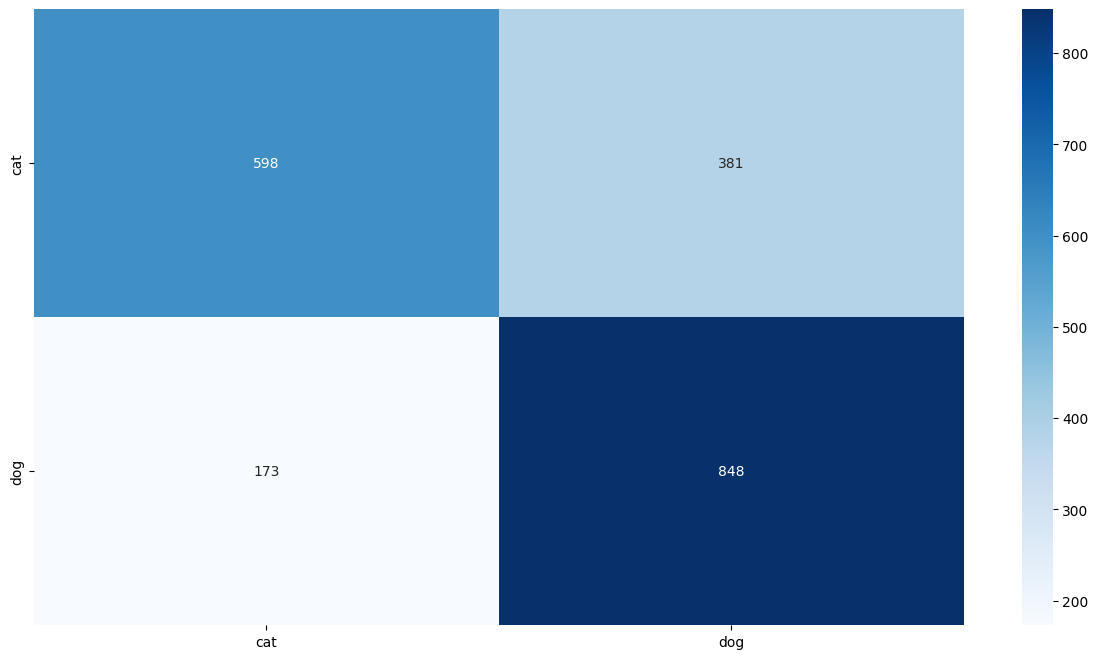

In [55]:
import seaborn as sns
plt.figure(figsize=(15,8))
sns.heatmap(confusion_matrix(test_labels,predictions), cmap='Blues', annot=True, fmt='g', xticklabels=classes_values, yticklabels=classes_values);